In [20]:
import api_nyt as nyt
import api_wikipedia as wiki
import manage_articles as mng
import statistics
import datetime
import pickle
import timeseries
import TextPreprocessing as txt
from datetime import date
import graphics
import matplotlib.pyplot as plt
import matching

articles = mng.load_articles("nyt2019.json")

In [21]:
#headlines = mng.getWordCounts(articles,'headline')
#with open("wordCount2019.txt", "wb") as fp:
#    pickle.dump(headlines, fp)
#top = mng.getTopWordsForWeek(headlines)
#distinctWords = mng.getDistinctWords(headlines)

headlines = []
with open("wordCount2019.txt", "rb") as fp:
    headlines = pickle.load(fp)
distinctWords = mng.getDistinctWords(headlines)

countsPerWeek = []
for w in distinctWords:
    countsPerWeek.append((w,mng.getCountPerWeek(headlines,w)))

ts = []
for c in countsPerWeek:
    ts.append(timeseries.Timeseries(c[0],c[1]))

In [22]:
nouns = txt.getNouns(distinctWords)
verbs = txt.getVerbs(distinctWords)

In [23]:
ts_sorted = sorted(ts, key=lambda x: sum(x.getCounts()), reverse=True)

In [24]:
keywords = []
top_amount = 50
for i in range(1,top_amount+1):
    print((i,ts_sorted[i].word))
    keywords.append(ts_sorted[i].word)

(1, 'says')
(2, 'trump')
(3, 'hong')
(4, 'kong')
(5, 'china')
(6, 'brexit')
(7, 'iran')
(8, 'u.k.')
(9, 'leader')
(10, 'election')
(11, 'protests')
(12, 'police')
(13, 'korea')
(14, 'president')
(15, 'say')
(16, 'north')
(17, 'may')
(18, 'india')
(19, 'johnson')
(20, 'south')
(21, 'protesters')
(22, 'russia')
(23, 'syria')
(24, 'attack')
(25, 'isis')
(26, 'boris')
(27, 'afghan')
(28, 'taliban')
(29, 'venezuela')
(30, 'deal')
(31, 'killed')
(32, 'minister')
(33, 'military')
(34, 'talks')
(35, 'killing')
(36, 'france')
(37, 'government')
(38, 'israel')
(39, 'zealand')
(40, 'u.n.')
(41, 'parliament')
(42, 'court')
(43, 'death')
(44, 'canada')
(45, 'dead')
(46, 'saudi')
(47, 'vote')
(48, 'party')
(49, 'japan')
(50, 'first')


In [25]:
m = matching.groupmatch(keywords, articles)
print("(ID, keyword, wiki link [simple matching], query [advanced matching], wiki link [advanced matching])")
for i in range(1,top_amount+1):
    if ts_sorted[i].word in m:
        print((i,ts_sorted[i].word, wiki.search_articles(ts_sorted[i].word, nmax=1),m[ts_sorted[i].word]["query"],m[ts_sorted[i].word]["link"]))
    else:
        print((i,ts_sorted[i].word, wiki.search_articles(ts_sorted[i].word, nmax=1),"topic already covered"))

(ID, keyword, wiki link [simple matching], query [advanced matching], wiki link [advanced matching])
(1, 'says', {1: 'Says'}, 'says president trump', {1: 'Donald_Trump'})
(2, 'trump', {1: 'Trump'}, 'topic already covered')
(3, 'hong', {1: 'Hong'}, 'hong kong protesters', {1: '2019–20_Hong_Kong_protests'})
(4, 'kong', {1: 'Kong'}, 'topic already covered')
(5, 'china', {1: 'China'}, 'china hong kong', {1: 'Hong_Kong'})
(6, 'brexit', {1: 'Brexit'}, 'brexit johnson prime', {1: 'Boris_Johnson'})
(7, 'iran', {1: 'Iran'}, 'iran u.s. trump', {1: 'United_States_sanctions_against_Iran'})
(8, 'u.k.', {1: 'United_Kingdom'}, 'u.k. brexit britain', {1: 'Brexit'})
(9, 'leader', {1: 'Leadership'}, 'leader president trump', {1: 'Donald_Trump'})
(10, 'election', {1: 'Election'}, 'election minister prime', {1: 'Prime_Minister_of_the_United_Kingdom'})
(11, 'protests', {1: 'Protest'}, 'protests hong kong', {1: '2019–20_Hong_Kong_protests'})
(12, 'police', {1: 'Police'}, 'police hong kong', {1: 'Hong_Kong_P

[datetime.date(2018, 12, 31), datetime.date(2019, 1, 7), datetime.date(2019, 1, 14), datetime.date(2019, 1, 21), datetime.date(2019, 1, 28), datetime.date(2019, 2, 4), datetime.date(2019, 2, 11), datetime.date(2019, 2, 18), datetime.date(2019, 2, 25), datetime.date(2019, 3, 4), datetime.date(2019, 3, 11), datetime.date(2019, 3, 18), datetime.date(2019, 3, 25), datetime.date(2019, 4, 1), datetime.date(2019, 4, 8), datetime.date(2019, 4, 15), datetime.date(2019, 4, 22), datetime.date(2019, 4, 29), datetime.date(2019, 5, 6), datetime.date(2019, 5, 13), datetime.date(2019, 5, 20), datetime.date(2019, 5, 27), datetime.date(2019, 6, 3), datetime.date(2019, 6, 10), datetime.date(2019, 6, 17), datetime.date(2019, 6, 24), datetime.date(2019, 7, 1), datetime.date(2019, 7, 8), datetime.date(2019, 7, 15), datetime.date(2019, 7, 22), datetime.date(2019, 7, 29), datetime.date(2019, 8, 5), datetime.date(2019, 8, 12), datetime.date(2019, 8, 19), datetime.date(2019, 8, 26), datetime.date(2019, 9, 2), d

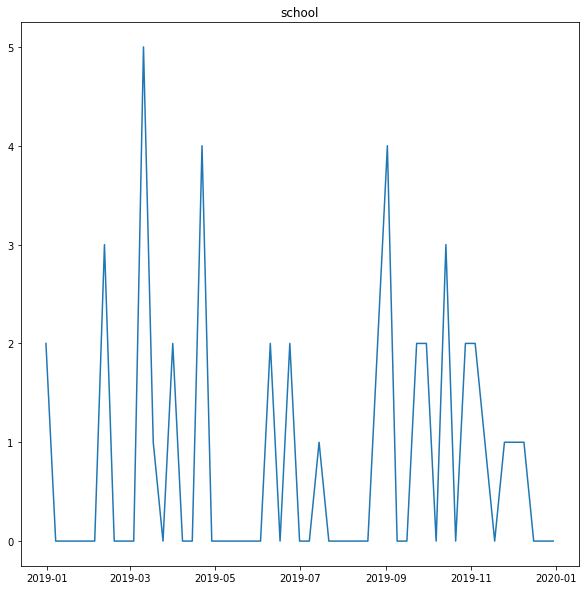

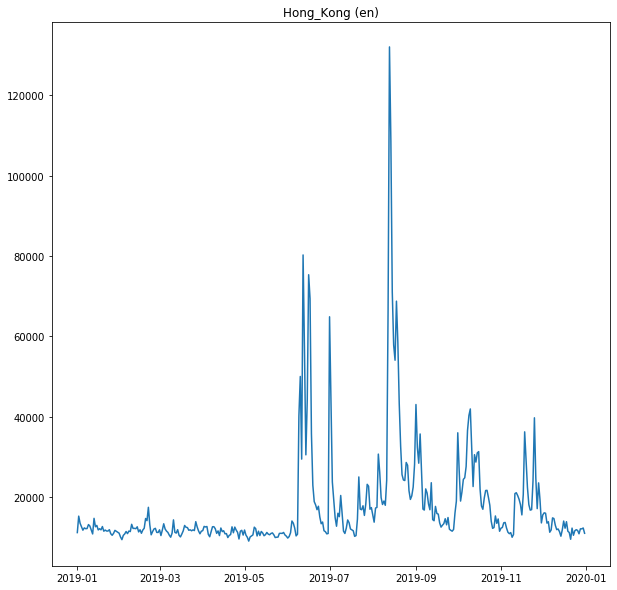

In [26]:
index = 188
graphics.plot_dataset(ts_sorted[index].word,ts_sorted[index].getCounts(),ts_sorted[index].getDates())
graphics.plot_wikipedia("Hong_Kong", date(2019,1,1), date(2019,12,31))